# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Set the device (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available. Using CPU.")
print(f"CUDA Version: {torch.version.cuda}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU is available.
CUDA Version: 11.8


# Constants

In [11]:
input_size = 3 * 32 * 32  # CIFAR-10 images are 32x32 with 3 channels
num_classes = 10
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# Load CIFAR-10 Dataset

In [14]:
tensor_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform= tensor_transform)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform= tensor_transform)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


# ANN model

In [4]:
# Step 1: Build ANN
class ANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 512)
        self.fc4 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input images
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
# Create the ANN model
ann_model = ANN(input_size, num_classes).to(device)

In [6]:
# The Loss and optimzer functions for ANN
ann_lossFunction = nn.CrossEntropyLoss()
ann_optimizer = torch.optim.SGD(ann_model.parameters(), lr=learning_rate, momentum=0.9)

In [7]:
# Training function
def training(model, lossFunction, optimizer):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dl, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = lossFunction(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            if i % 200 == 199:  # Print every 200 batches
                avg_loss = running_loss / 200
                accuracy = correct / total
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_dl)}], '
                      f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}')
                running_loss = 0.0
                correct = 0
                total = 0



**Training ANN model**

In [8]:
# Training ANN model
training(ann_model, ann_lossFunction, ann_optimizer)

Epoch [1/10], Batch [200/500], Loss: 1.9880, Accuracy: 0.29
Epoch [1/10], Batch [400/500], Loss: 1.6581, Accuracy: 0.41
Epoch [2/10], Batch [200/500], Loss: 1.4843, Accuracy: 0.47
Epoch [2/10], Batch [400/500], Loss: 1.4475, Accuracy: 0.49
Epoch [3/10], Batch [200/500], Loss: 1.3101, Accuracy: 0.54
Epoch [3/10], Batch [400/500], Loss: 1.3032, Accuracy: 0.54
Epoch [4/10], Batch [200/500], Loss: 1.1959, Accuracy: 0.58
Epoch [4/10], Batch [400/500], Loss: 1.2087, Accuracy: 0.57
Epoch [5/10], Batch [200/500], Loss: 1.0758, Accuracy: 0.62
Epoch [5/10], Batch [400/500], Loss: 1.1164, Accuracy: 0.61
Epoch [6/10], Batch [200/500], Loss: 0.9870, Accuracy: 0.65
Epoch [6/10], Batch [400/500], Loss: 1.0178, Accuracy: 0.64
Epoch [7/10], Batch [200/500], Loss: 0.8754, Accuracy: 0.69
Epoch [7/10], Batch [400/500], Loss: 0.9329, Accuracy: 0.67
Epoch [8/10], Batch [200/500], Loss: 0.7982, Accuracy: 0.72
Epoch [8/10], Batch [400/500], Loss: 0.8418, Accuracy: 0.70
Epoch [9/10], Batch [200/500], Loss: 0.7

In [9]:
def eval(model, loader):
    model.eval()
    with torch.no_grad():
        all_labels = []
        all_predictions = []
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    if(loader == test_dl):
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        confusion = confusion_matrix(all_labels, all_predictions)
        print(f"Results for testing: ")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        confMatrix = ConfusionMatrixDisplay(confusion)
        confMatrix.plot()
    else:
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f'train accuracy : {accuracy:.3f}')




In [10]:
# train accuracy
eval(ann_model, train_dl)

train accuracy : 0.839


Results for testing: 
Accuracy: 0.561
Precision: 0.571
Recall: 0.561


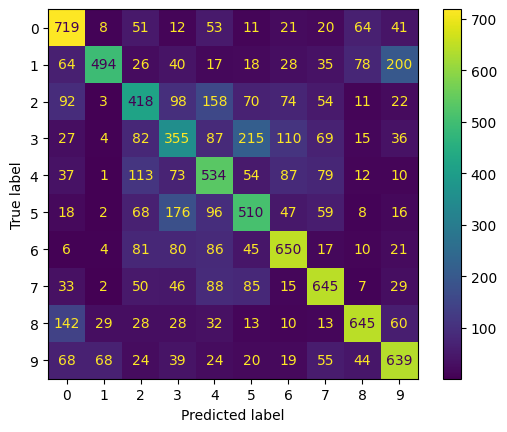

In [11]:
#test ANN
eval(ann_model, test_dl)

# Pretrained models


1.   **VGG16**

In [12]:
vgg16_model = torchvision.models.vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, num_classes)
vgg16_model = vgg16_model.to(device)

# Define loss function and optimizer for transfer learning
vgg16_lossFunction = nn.CrossEntropyLoss()
vgg16_optimizer = torch.optim.SGD(vgg16_model.parameters(), lr=learning_rate, momentum=0.9)

C:\Users\mohdn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mohdn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Fine-tune the VGG16 model
training(vgg16_model, vgg16_lossFunction, vgg16_optimizer)

Epoch [1/10], Batch [200/500], Loss: 1.0036, Accuracy: 0.66
Epoch [1/10], Batch [400/500], Loss: 0.6422, Accuracy: 0.79
Epoch [2/10], Batch [200/500], Loss: 0.4121, Accuracy: 0.87
Epoch [2/10], Batch [400/500], Loss: 0.4012, Accuracy: 0.87
Epoch [3/10], Batch [200/500], Loss: 0.2631, Accuracy: 0.91
Epoch [3/10], Batch [400/500], Loss: 0.2895, Accuracy: 0.90
Epoch [4/10], Batch [200/500], Loss: 0.1778, Accuracy: 0.94
Epoch [4/10], Batch [400/500], Loss: 0.2005, Accuracy: 0.93
Epoch [5/10], Batch [200/500], Loss: 0.1325, Accuracy: 0.96
Epoch [5/10], Batch [400/500], Loss: 0.1466, Accuracy: 0.95
Epoch [6/10], Batch [200/500], Loss: 0.0976, Accuracy: 0.97
Epoch [6/10], Batch [400/500], Loss: 0.1085, Accuracy: 0.97
Epoch [7/10], Batch [200/500], Loss: 0.0781, Accuracy: 0.97
Epoch [7/10], Batch [400/500], Loss: 0.0933, Accuracy: 0.97
Epoch [8/10], Batch [200/500], Loss: 0.0544, Accuracy: 0.98
Epoch [8/10], Batch [400/500], Loss: 0.0649, Accuracy: 0.98
Epoch [9/10], Batch [200/500], Loss: 0.0

In [14]:
# Train accuracy
eval(vgg16_model, train_dl)

train accuracy : 0.992


Results for testing: 
Accuracy: 0.884
Precision: 0.885
Recall: 0.884


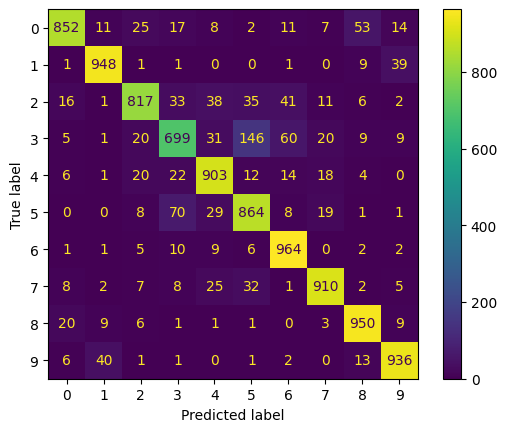

In [15]:
#Test vgg16_model
eval(vgg16_model, test_dl)


2.   **GoogleNet**

In [16]:
googlenet_model = torchvision.models.googlenet(pretrained=True)
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model = googlenet_model.to(device)

# Define loss function and optimizer for transfer learning
googlenet_model_lossFunction = nn.CrossEntropyLoss()
googlenet_model_optimizer = torch.optim.SGD(googlenet_model.parameters(), lr=learning_rate, momentum=0.9)

C:\Users\mohdn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mohdn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\mohdn/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:

In [17]:
# Training googlenet_model
training(googlenet_model, googlenet_model_lossFunction, googlenet_model_optimizer)

Epoch [1/10], Batch [200/500], Loss: 1.3179, Accuracy: 0.54
Epoch [1/10], Batch [400/500], Loss: 0.8706, Accuracy: 0.71
Epoch [2/10], Batch [200/500], Loss: 0.6161, Accuracy: 0.79
Epoch [2/10], Batch [400/500], Loss: 0.6134, Accuracy: 0.79
Epoch [3/10], Batch [200/500], Loss: 0.4333, Accuracy: 0.85
Epoch [3/10], Batch [400/500], Loss: 0.4573, Accuracy: 0.85
Epoch [4/10], Batch [200/500], Loss: 0.3246, Accuracy: 0.89
Epoch [4/10], Batch [400/500], Loss: 0.3629, Accuracy: 0.88
Epoch [5/10], Batch [200/500], Loss: 0.2519, Accuracy: 0.91
Epoch [5/10], Batch [400/500], Loss: 0.2867, Accuracy: 0.90
Epoch [6/10], Batch [200/500], Loss: 0.2118, Accuracy: 0.93
Epoch [6/10], Batch [400/500], Loss: 0.2333, Accuracy: 0.92
Epoch [7/10], Batch [200/500], Loss: 0.1508, Accuracy: 0.95
Epoch [7/10], Batch [400/500], Loss: 0.2003, Accuracy: 0.93
Epoch [8/10], Batch [200/500], Loss: 0.1317, Accuracy: 0.95
Epoch [8/10], Batch [400/500], Loss: 0.1548, Accuracy: 0.94
Epoch [9/10], Batch [200/500], Loss: 0.1

In [18]:
# Train accuracy
eval(googlenet_model, train_dl)

train accuracy : 0.981


Results for testing: 
Accuracy: 0.812
Precision: 0.813
Recall: 0.812


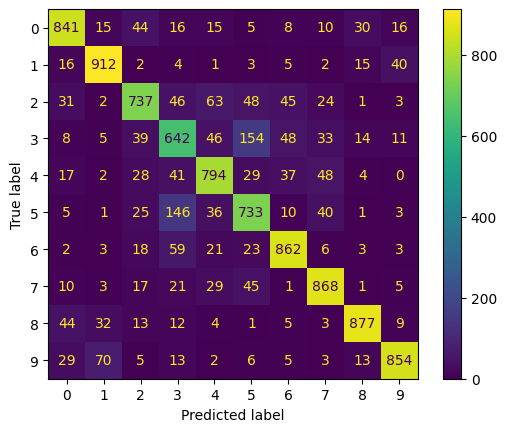

In [19]:
#Test googlenet_model
eval(googlenet_model, test_dl)

3.   **Resnet50**

In [20]:
resnet_model = torchvision.models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

# Define loss function and optimizer for transfer learning
resnet_model_lossFunction = nn.CrossEntropyLoss()
resnet_model_optimizer = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


In [21]:
# Training resnet_model
training(resnet_model, resnet_model_lossFunction, resnet_model_optimizer)

Epoch [1/10], Batch [200/500], Loss: 1.1595, Accuracy: 0.61
Epoch [1/10], Batch [400/500], Loss: 0.6940, Accuracy: 0.76
Epoch [2/10], Batch [200/500], Loss: 0.5297, Accuracy: 0.82
Epoch [2/10], Batch [400/500], Loss: 0.8314, Accuracy: 0.73
Epoch [3/10], Batch [200/500], Loss: 0.4213, Accuracy: 0.85
Epoch [3/10], Batch [400/500], Loss: 0.4272, Accuracy: 0.85
Epoch [4/10], Batch [200/500], Loss: 0.2490, Accuracy: 0.91
Epoch [4/10], Batch [400/500], Loss: 0.2656, Accuracy: 0.91
Epoch [5/10], Batch [200/500], Loss: 0.1601, Accuracy: 0.94
Epoch [5/10], Batch [400/500], Loss: 0.2054, Accuracy: 0.93
Epoch [6/10], Batch [200/500], Loss: 0.1127, Accuracy: 0.96
Epoch [6/10], Batch [400/500], Loss: 0.1406, Accuracy: 0.95
Epoch [7/10], Batch [200/500], Loss: 0.0765, Accuracy: 0.97
Epoch [7/10], Batch [400/500], Loss: 0.1132, Accuracy: 0.96
Epoch [8/10], Batch [200/500], Loss: 0.0680, Accuracy: 0.98
Epoch [8/10], Batch [400/500], Loss: 0.0902, Accuracy: 0.97
Epoch [9/10], Batch [200/500], Loss: 0.0

In [22]:
# Train accuracy
eval(resnet_model, train_dl)

train accuracy : 0.981


Results for testing: 
Accuracy: 0.823
Precision: 0.827
Recall: 0.823


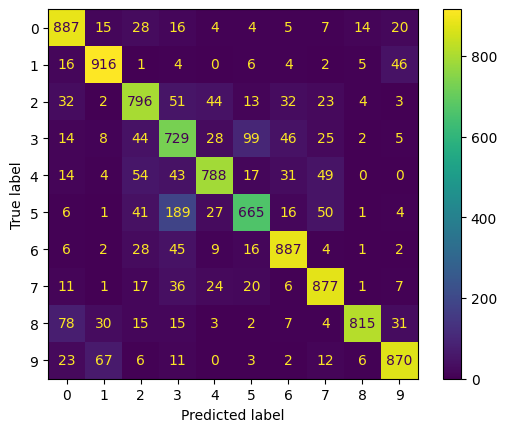

In [23]:
#Test resnet_model
eval(resnet_model, test_dl)

In [24]:
classes = classes = ('plane', 'car', 'bird', 'cat','deer',
                     'dog', 'frog', 'horse', 'ship', 'truck')

In [27]:
num_images_to_show = 5
test_images, test_labels = next(iter(test_dl))
test_images, test_labels = test_images.to(device), test_labels.to(device)

def visualize_output(model, model_name):
    model.eval()
    with torch.no_grad():
        model_outputs = model(test_images)

    _, predicted_classes = torch.max(model_outputs, 1)

    plt.figure(figsize=(12, 10))
    for i in range(num_images_to_show):
        plt.subplot(num_images_to_show, 1, i+1)
        image = test_images[i].cpu().numpy()
        image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        image = image * 0.5 + 0.5  # Denormalize image
        plt.imshow(image)
        plt.title(f'Pred: {classes[predicted_classes[i]]}, True: {classes[test_labels[i]]}')
        plt.axis('off')
    plt.suptitle(f'{model_name} Model - Output for Test Images', y=1.02)
    plt.tight_layout()





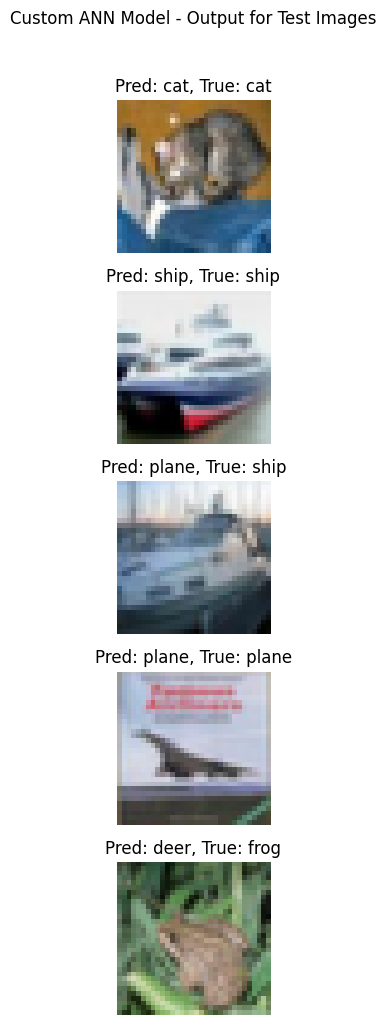

In [28]:
visualize_output(ann_model, 'Custom ANN')

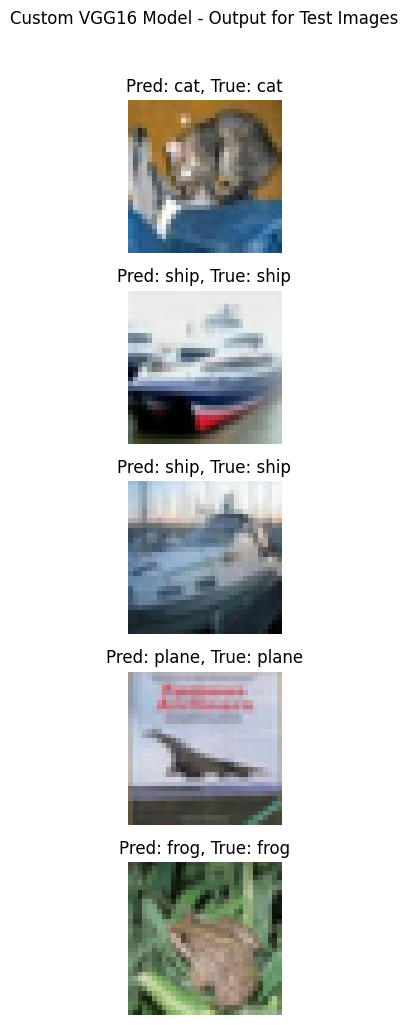

In [29]:
visualize_output(vgg16_model, 'Custom VGG16')

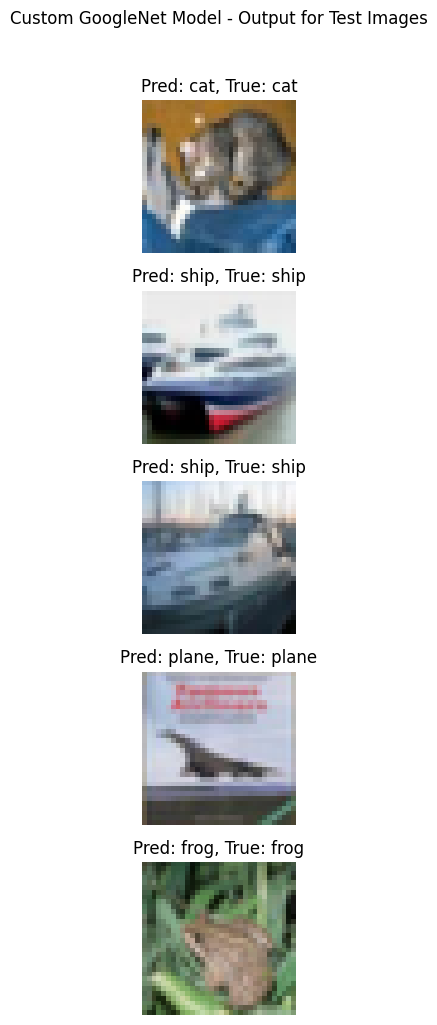

In [30]:
visualize_output(googlenet_model, 'Custom GoogleNet')

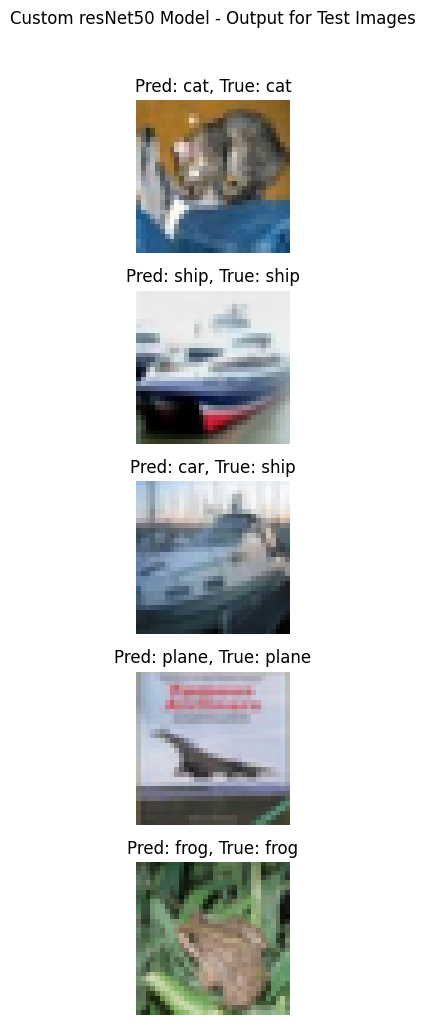

In [31]:
visualize_output(resnet_model, 'Custom resNet50')